In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from torch.autograd import Variable
from sklearn.decomposition import PCA
import pandas as pd
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
import matplotlib
from matplotlib.pyplot import figure

In [2]:
torch.manual_seed(1)

In [3]:
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=False)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

print("train_dataset size:", len(train_dataset),"\ntest_dataset size:", len(test_dataset))

train_dataset size: 60000 
test_dataset size: 10000


In [4]:
def train_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size = batch_size, 
                                           shuffle=True)
    return train_loader


def test_loader(batch_size):
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)
    return test_loader

In [5]:
class DNN(nn.Module):
    def __init__(self,):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:

def trainFunc(model,num_epochs,train_batch_size,status_interval):
    model.train()
    print('strated')
    train_load = train_loader(train_batch_size)
    n_total_steps = len(train_load)
    train_losses = []
    train_epoch = []
    train_acc = []
    epoch = 0
    modelParamWgt = pd.DataFrame()
    trainAvgLossArr = []
    trainAvgAccArr = []
    firstParaWgt = {}

   
    for name, param in model.named_parameters():
        if 'fc1.weight' in name:  
            firstParaWgt = param.detach().numpy()
            break
    for epoch in range (num_epochs):
        epoch += 1
        n_correct = 0
        n_samples = 0
        lossSum =0
        totalacc=0
        epoch_df = pd.DataFrame()

        for i, (images, labels) in enumerate(train_load):  
            images, labels = Variable(images),Variable(labels)
            
            optimizer.zero_grad()
            
            
            prediction = model(images)

            images.requires_grad = True

            loss = loss_func(prediction, labels)
            lossSum += loss.detach().numpy()

           
            
            loss.backward()

            optimizer.step()

            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            acc = 100.0 * n_correct / n_samples
            totalacc += acc

            train_losses.append(loss.item())
            train_acc.append(acc)
            train_epoch.append(epoch)

            
            if (i+1) % status_interval == 0:
                print (f'Train O/P: Epoch [{epoch}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}',end= '\r',flush = True)
        
       
        for name, parameter in model.named_parameters():
          
            if'weight' in name:
                weights = torch.nn.utils.parameters_to_vector(parameter).detach().numpy() 
                epoch_df = pd.concat([epoch_df, pd.DataFrame(weights).T], axis = 1) 

        modelParamWgt = pd.concat([modelParamWgt, epoch_df], axis = 0)     

       
        epochLoss = lossSum/n_total_steps
        epochAcc = totalacc/n_total_steps
        trainAvgLossArr.append(epochLoss)    
        trainAvgAccArr.append(epochAcc)
                       
    return train_epoch,train_losses,train_acc,trainAvgLossArr,trainAvgAccArr, modelParamWgt, firstParaWgt

In [7]:
def testFunction(model,loss_func,test_batch_size): 
    test_load = test_loader(test_batch_size)
    model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        testLoss = 0
        count = 0
        for images, labels in test_load:
            images, labels = Variable(images),Variable(labels)
            
            prediction = model(images)
            testLoss += loss_func(prediction,labels).item()
            # max returns (value ,index)
            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            count += 1
    netTest_loss = testLoss/count
    netTest_acc1 = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test images: {netTest_acc1}% & Test Loss: {netTest_loss}',end= '\r',flush = True)
    return netTest_acc1, netTest_loss

In [8]:
def pcaOps(paramDF,itr):
    pcaOperation =  PCA(n_components=2)

    pcaVal = pcaOperation.fit_transform(paramDF)

    itrData = np.full((pcaVal.shape[0],1),itr)

    pcaDf = pd.DataFrame(np.append(pcaVal,itrData,axis=1),columns=['x','y','Itr No.'])

    return pcaDf


In [9]:
a=[]
tempModel = DNN()
for i in tempModel.parameters():
    a.append(torch.numel(i))
print(f'Total no of parameters:{np.sum(a)}')

Total no of parameters:418060


In [10]:
max_epochs = 45
all_df = pd.DataFrame()
columns=["x","y","Times"]
trainAllacc={}
testAllacc={}
trainAllloss={}
testAllloss={}
train_batch_size = 1000
test_batch_size = 1000
status_interval = 60
loss_func = nn.CrossEntropyLoss()
firstLayer = pd.DataFrame()

for count in range(8):

    j = copy.deepcopy(count)

    j = DNN()  

    print("Time: "+str(count))
    optimizer = torch.optim.Adam(j.parameters(),lr = 0.0004,weight_decay=1e-4)
    model_name1 = "Times:"+str(count)  
    
    train_epoch,train_losses,train_acc,trainAvgLoss,trainAvgAccArr, modelParamWgt, firstParaWgt = trainFunc(j,max_epochs,train_batch_size,status_interval)
    testAcc, testLoss = testFunction(j,loss_func,test_batch_size)

    all_df = pd.concat([all_df, modelParamWgt], ignore_index=True)

    
    testAllacc[count] = testAcc
    trainAllloss[count] = trainAvgLoss
    testAllloss[count] = testLoss
    trainAllacc[count] = trainAvgAccArr


Time: 0
strated
Time: 1y of the network on the test images: 98.04% & Test Loss: 0.06357570616528392
strated
Time: 2y of the network on the test images: 98.01% & Test Loss: 0.06365276854485273
strated
Time: 3y of the network on the test images: 97.98% & Test Loss: 0.060919372644275424
strated
Time: 4y of the network on the test images: 97.98% & Test Loss: 0.06468471838161349
strated
Time: 5y of the network on the test images: 97.87% & Test Loss: 0.06479563675820828
strated
Time: 6y of the network on the test images: 98.05% & Test Loss: 0.05972613831982017
strated
Time: 7y of the network on the test images: 98.03% & Test Loss: 0.06504640402272344
strated


In [11]:
trainAccArr = []
for key,values in enumerate(trainAllacc):
    trainAccArr.append(trainAllacc[key])
trainLossArr = []
for key,values in enumerate(trainAllloss):
    trainLossArr.append(trainAllloss[key])


In [12]:
all_df

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,8.407488e-03,3.342530e-05,-1.456898e-05,-1.231874e-05,5.416785e-05,3.672393e-03,5.604144e-04,4.590647e-04,1.064807e-02,-9.778960e-03,...,0.010897,-0.138840,0.063458,-0.071111,0.081551,1.380859e-01,-0.043712,-0.063955,0.040641,-0.140893
1,8.579924e-04,-7.691955e-06,3.082593e-05,1.864881e-07,2.536470e-06,-6.868090e-05,-7.803570e-06,-3.594812e-05,1.683690e-03,-1.337988e-03,...,0.002338,-0.150779,0.069668,-0.070547,0.088664,1.476858e-01,-0.058468,-0.069548,0.035191,-0.160233
2,-4.852928e-06,-6.665608e-07,-1.637774e-06,1.594694e-08,-1.883499e-08,1.961117e-06,-2.079891e-06,-1.123322e-06,7.284473e-05,-3.240413e-05,...,0.000820,-0.155322,0.071663,-0.070124,0.091016,1.527165e-01,-0.069926,-0.073310,0.033343,-0.176264
3,-8.169328e-07,3.363233e-08,-8.366509e-08,4.392708e-11,1.042142e-09,-1.770810e-07,5.613196e-08,-2.368340e-08,-2.996627e-06,2.475838e-06,...,-0.000679,-0.158232,0.073486,-0.070826,0.092659,1.566794e-01,-0.078318,-0.076016,0.032952,-0.187858
4,4.876679e-08,-1.464084e-09,-2.386467e-09,-4.365283e-11,-2.059952e-10,1.211540e-08,4.804912e-09,-1.310935e-09,3.535167e-08,-8.517954e-08,...,-0.001463,-0.161688,0.074897,-0.071756,0.093622,1.600592e-01,-0.085428,-0.079052,0.033002,-0.200261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,6.164777e-39,1.547222e-38,1.516589e-38,-3.752871e-39,9.255547e-39,1.811786e-39,-7.925618e-39,3.001485e-39,-1.157317e-38,1.595402e-38,...,0.124189,0.099207,-0.173301,0.078643,-0.275532,3.201340e-22,0.188228,-0.009141,0.021338,-0.077917
356,6.164777e-39,1.547222e-38,1.516589e-38,-3.752871e-39,9.255547e-39,1.811786e-39,-7.925618e-39,3.001485e-39,-1.157317e-38,1.595402e-38,...,0.125344,0.099961,-0.175220,0.079881,-0.277923,-1.301828e-23,0.189503,-0.009321,0.022336,-0.078720
357,6.164777e-39,1.547222e-38,1.516589e-38,-3.752871e-39,9.255547e-39,1.811786e-39,-7.925618e-39,3.001485e-39,-1.157317e-38,1.595402e-38,...,0.126216,0.100594,-0.177074,0.081220,-0.280542,2.537435e-25,0.190798,-0.009410,0.023207,-0.079390
358,6.164777e-39,1.547222e-38,1.516589e-38,-3.752871e-39,9.255547e-39,1.811786e-39,-7.925618e-39,3.001485e-39,-1.157317e-38,1.595402e-38,...,0.127547,0.101791,-0.178391,0.082908,-0.282499,1.011884e-26,0.192035,-0.009407,0.024443,-0.079902


In [13]:
train_acc_df = pd.DataFrame(trainAccArr)
train_acc_data = np.array(train_acc_df).flatten()

train_loss_df = pd.DataFrame(trainLossArr)
train_loss_data = np.array(train_loss_df).flatten()

print(f'Shape of Loss:{np.shape(train_loss_data)} & Shape of Acc: {np.shape(train_acc_data)}')


Shape of Loss:(360,) & Shape of Acc: (360,)


In [14]:
t1 = all_df
print(pd.DataFrame(t1))

              0             1             2             3             4    \
0    8.407488e-03  3.342530e-05 -1.456898e-05 -1.231874e-05  5.416785e-05   
1    8.579924e-04 -7.691955e-06  3.082593e-05  1.864881e-07  2.536470e-06   
2   -4.852928e-06 -6.665608e-07 -1.637774e-06  1.594694e-08 -1.883499e-08   
3   -8.169328e-07  3.363233e-08 -8.366509e-08  4.392708e-11  1.042142e-09   
4    4.876679e-08 -1.464084e-09 -2.386467e-09 -4.365283e-11 -2.059952e-10   
..            ...           ...           ...           ...           ...   
355  6.164777e-39  1.547222e-38  1.516589e-38 -3.752871e-39  9.255547e-39   
356  6.164777e-39  1.547222e-38  1.516589e-38 -3.752871e-39  9.255547e-39   
357  6.164777e-39  1.547222e-38  1.516589e-38 -3.752871e-39  9.255547e-39   
358  6.164777e-39  1.547222e-38  1.516589e-38 -3.752871e-39  9.255547e-39   
359  6.164777e-39  1.547222e-38  1.516589e-38 -3.752871e-39  9.255547e-39   

              5             6             7             8             9    

In [15]:
t1 = np.array(t1)
pca = PCA(n_components=2)
new_data = pca.fit_transform(t1)
allEpochDf = pd.DataFrame(new_data,columns=['x','y'])

eps_each_time = [i for i in range(max_epochs)] * 8
times = np.repeat([i for i in range(8)],max_epochs)

allEpochDf['Epoch']=eps_each_time
allEpochDf['Iteration']=(times)
allEpochDf["Acc"] = train_acc_data
allEpochDf["Loss"] = train_loss_data

allEpochDf


,x,y,Epoch,Iteration,Acc,Loss
0,3.282694,-2.654480,0,0,45.471451,1.297160
1,4.049080,-3.262875,1,0,87.937951,0.397261
2,4.563258,-3.663340,2,0,91.432531,0.294389
3,4.991952,-4.004411,3,0,92.726540,0.249855
4,5.363611,-4.295671,4,0,93.782002,0.215795
...,...,...,...,...,...,...
355,11.606400,7.357240,40,7,99.675107,0.020525
356,11.576238,7.338970,41,7,99.704882,0.019201
357,11.545330,7.319335,42,7,99.727565,0.018324
358,11.512426,7.298418,43,7,99.764686,0.017649


In [16]:
epoch3Df = allEpochDf.loc[(allEpochDf['Epoch']+1)%3 == 0]
epoch3Df = epoch3Df.reset_index(drop=True)
epoch3Df

,x,y,Epoch,Iteration,Acc,Loss
0,4.563258,-3.663340,2,0,91.432531,0.294389
1,5.688645,-4.562304,5,0,94.420400,0.190199
2,6.423463,-5.170873,8,0,96.020462,0.138675
3,6.895989,-5.559428,11,0,97.001880,0.105956
4,7.221544,-5.816992,14,0,97.688775,0.084796
...,...,...,...,...,...,...
115,11.731924,7.432790,32,7,99.284642,0.030849
116,11.709902,7.417514,35,7,99.447130,0.026420
117,11.659074,7.390266,38,7,99.639077,0.022668
118,11.576238,7.338970,41,7,99.704882,0.019201


In [17]:
test = np.array(epoch3Df.Acc)
mv = []
for i in range(len(test)):
    mv.append(str(int(test[i])))
len(mv)

120

In [18]:
cmap = ['red', 'blue', 'green', 'purple', 'orange', 'magenta', 'brown', 'black']


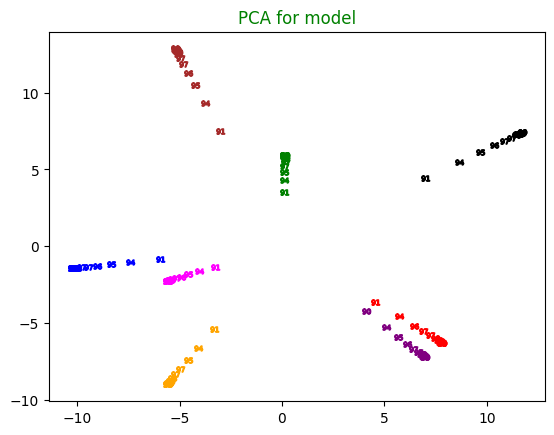

<Figure size 5000x2500 with 0 Axes>

In [19]:

for i in range(len(mv)):
    m = mv[i]
    c = epoch3Df['Iteration'][i]
    plt.scatter(epoch3Df['x'][i],epoch3Df['y'][i],marker=f'${m}$',color = cmap[c])
    plt.title("PCA for model",color="g")
    
plt.figure(figsize=[10,5],dpi=500)

plt.show()

In [20]:
layer1_Df = all_df.iloc[:,0:7840]


In [21]:
t2 = layer1_Df 
t2 = np.array(t2)
pca = PCA(n_components=2)
new_data2 = pca.fit_transform(t2)

In [22]:
layer1Df = pd.DataFrame(new_data2,columns=['x','y'])

eps_each_time = [i for i in range(max_epochs)] * 8
times = np.repeat([i for i in range(8)],max_epochs)

layer1Df['Epoch']=eps_each_time
layer1Df['Iteration']=(times)
layer1Df["Acc"] = train_acc_data
layer1Df["Loss"] = train_loss_data

layer1Df

,x,y,Epoch,Iteration,Acc,Loss
0,0.451368,0.286723,0,0,45.471451,1.297160
1,0.684173,0.353410,1,0,87.937951,0.397261
2,0.818192,0.400265,2,0,91.432531,0.294389
3,0.921803,0.437388,3,0,92.726540,0.249855
4,1.026168,0.463571,4,0,93.782002,0.215795
...,...,...,...,...,...,...
355,-0.243480,-0.298961,40,7,99.675107,0.020525
356,-0.245065,-0.296572,41,7,99.704882,0.019201
357,-0.242307,-0.293018,42,7,99.727565,0.018324
358,-0.240387,-0.292582,43,7,99.764686,0.017649


In [23]:
test = np.array(layer1Df.Acc)
mv = []
for i in range(len(test)):
    mv.append(str(int(test[i])))


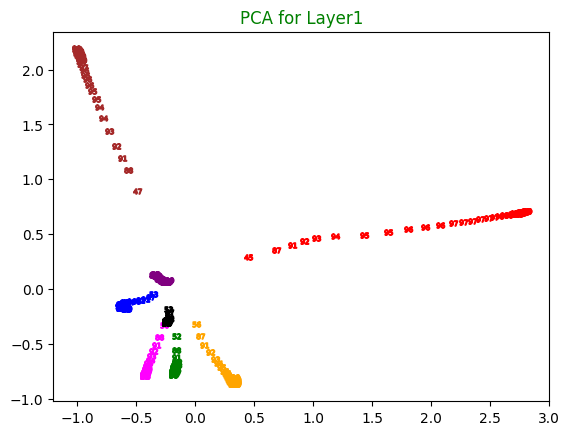

In [24]:
for i in range(len(mv)):
    m = mv[i]
    c = layer1Df['Iteration'][i]
    plt.scatter(layer1Df['x'][i],layer1Df['y'][i],marker=f'${m}$',color = cmap[c])
    plt.title("PCA for Layer1",color="g")


plt.show()